<a href="https://colab.research.google.com/github/amirhnazerii/DNN_RealEstatePriceEstimator/blob/main/DNN_RealEstatePriceEstimator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Neural Network Real Estate Price Estimator


__author__ = "Amir Nazeri" 

__copyright__ = "Copyright 2021, The Advanced Neural Network Project @CU-ICAR"

__license__ = "GPL"

__version__ = "2.6"

__email__ = "anazeri@clemson.edu"

A Deep Neural Network (from scartch) to predict the house price in Boston. 


## Dataset Description
 This data was collected in 1978 and each of the 506 entries represents aggregate information about homes from various suburbs located in Boston. 

The dataset header:

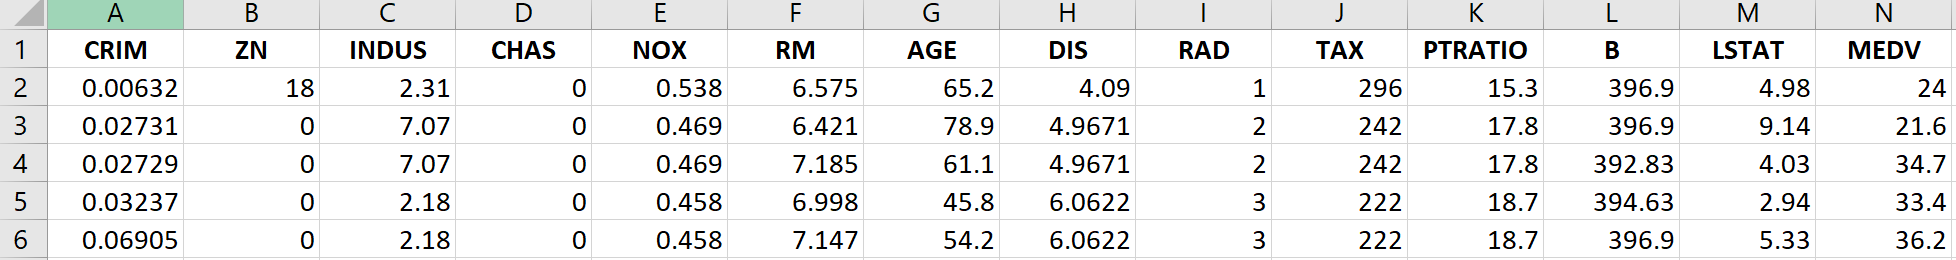

**Features**:
- CRIM: per capita crime rate by town
- ZN: proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS: proportion of non-retail business acres per town
- CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
- NOX: nitric oxides concentration (parts per 10 million)
- RM: average number of rooms per dwelling
- AGE: proportion of owner-occupied units built prior to 1940
- DIS: weighted distances to five Boston employment centres
- RAD: index of accessibility to radial highways
- TAX: full-value property-tax rate per 10,000usd
- PTRATIO: pupil-teacher ratio by town
- B: $1000(B_k - 0.63)^2$ where $B_k$ is the proportion of blacks by town
- LSTAT: percentage lower status of the population

**Label**:
- MEDV: This is the median value of owner-occupied homes in $1000s

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Dataset Preprocessing


- The raw dataset is **randomly** divided into training set and test set according to the given size of the training set.
- **Min-max scaler** transforms features X by scaling each feature to a given range $[a, b]$. The transformation is given by:
$$X_{\text{std}}=\frac{X - X_{\text{min}}}{X_{\text{max}}-X_{\text{min}}}$$
$$X_{\text{scaled}}=X_{\text{std}}\cdot(b-a) + a$$

In [ ]:
class DataPreProcessing:
    def __init__(self):
        pass
    
    @staticmethod
    def read_data(file, separator):
        """
        Use the Numpy function fromfile() to load the dataset from the given file.
        
        Parameters
        ----------
        file: string
            String path of the data file.
        separator: string
            Separator between items if file is a text file.

        Return
        ----------
        data: ndarray
            Data read from the given file.
        """
        data = np.fromfile(file, dtype=float, sep= separator)
        data= data.reshape(-1,14)
        return data

    @staticmethod
    def train_test_split(data, train_size, shuffle=True):
        """
        Split the given data into random train and test subsets. 
        
        Parameters
        ----------
        data: ndarray
            Input of the given data.
        train_size: float
            The proportion of the dataset to include in the train split.
        shuffle: bool
            Whether or not to shuffle the data before splitting.
   
        Return
        ----------
        train_data: ndarray
            Output of the training data.
        test_data: ndarray
            Output of the test data.
        """
        dataset = data
        rows, _  = dataset.shape
        num_train_data= int(train_size*rows)
        if shuffle:
           np.random.shuffle(dataset)

        train_data = dataset[:num_train_data,:]
        test_data = dataset[num_train_data:,:]

        return train_data , test_data

    @staticmethod
    def minmax_scale(X, feature_range=(0, 1)):
        """
        Transform features X by scaling each feature to a given range. 
        
        Parameters
        ----------
        data: ndarray
            Input of the given data.
        feature_range: tuple
            Desired range of transformed data.

        Return
        ----------
        X_scaled: ndarray
            Output of the scaled features.
        """
        _, columns = X.shape
        a = feature_range[0]
        b = feature_range[1]
        # X_scaled = []
        for i in range(columns):
            X_std = (X[:,i]-np.min(X[:,i]))/(np.max(X[:,i])-np.min(X[:,i]))    #TODO: check axis = 1 0r 0
            X[:,i]= X_std*(b-a)+a
            X_scaled = X
        return X_scaled




- `X_train` is an $n\times m$ matrix where $n$ is the number of features and $m$ is the number of training examples. In this project, $n=13$ and $m=\lfloor0.8\times506\rfloor$.
- The shape of `y_train` is $1\times m$ where $m$ is the number of training examples.
- `X_test` and `y_test` have the similar shape.

In [ ]:
# Init the train size
train_size = 0.8


data_preprocessor = DataPreProcessing()

# read the data from the data file
# file = "housing.data"
file = "housing.data"
separator = ' '
dataset= data_preprocessor.read_data(file, separator)
print(dataset.shape)
# split the data random train and test subsets.

train_data , test_data = data_preprocessor.train_test_split(dataset,train_size,True)
train_data= np.transpose(train_data)
test_data = np.transpose(test_data)
print(train_data.shape , test_data.shape)

# split the training subset into X_train and y_train
rows, columns = train_data.shape
y_train = train_data[-1:,:]                                           
X_train = train_data[0:-1,:]
# print(X_train.shape , y_train.shape)
# print(y_train)


# split the test subset into X_test and y_test
rows, columns = test_data.shape
y_test = test_data[-1:,:]                                           
X_test = test_data[0:-1,:]

# 0-1 scale X_train and X_test respectively
X_train = np.transpose(X_train)
X_test = np.transpose(X_test)

X_train_scaled = data_preprocessor.minmax_scale(X_train, feature_range=(0, 1))
X_test_scaled = data_preprocessor.minmax_scale(X_test, feature_range=(0, 1))

X_train = np.transpose(X_train_scaled)
X_test = np.transpose(X_test_scaled)
np.savetxt('X_train.txt', X_train, fmt='%.4f', delimiter="  ")
np.savetxt('X_test.txt', X_test, fmt='%.4f', delimiter="  ")
np.savetxt('y_train.txt', y_train, fmt='%.4f', delimiter="   ")

# reshape X_train, X_test, y_train, and y_test to satisfy the requirments          


(506, 14)
(14, 404) (14, 102)


## Shallow Neural Network
a shallow neural network with **only one hidden layer** to predict the Boston house price.

### Initialize model parameters
Since the model is a two-layer (one hidden layer and an output layer) neural network, model parameters will be $W_1$, $b_1$, $W_2$, and $b_2$. 


In [ ]:
def init_params(input_layer_size, hidden_layer_size, output_layer_size):
    """
    Initialize model parameters based on He initialization method.
        
    Parameters
    ----------
    input_layer_size: int
        Number of features in the input sample.
    hidden_layer_size: int
        Number of neurons in the hidden layer.
    output_layer_size: int
        Number of neurons in the output layer.

    Return
    ----------
    W1: ndarray
        Output of initialized W1.
    b1: ndarray
        Output of initialized b1.
    W2: ndarray
        Output of initialized W2.
    b2: ndarray
        Output of initialized b2.
    """
    n_0 = input_layer_size
    n_1 = hidden_layer_size
    n_2 = output_layer_size
    W1 = np.random.randn(n_1,n_0)*np.sqrt(2/n_0)
    b1 = np.zeros((n_1,1))
    W2 = np.random.randn(n_2,n_1)*np.sqrt(2/n_1)
    b2 = np.zeros((n_2,1))
    return W1 , b1, W2, b2

ReLU is the most common activation function used in neural networks. 
$$a = \begin{cases}
   z &\text{if } z>0 \\
   0 &\text{if } z\le0
\end{cases}$$

$$\frac{da}{dz} = \begin{cases}
   1 &\text{if } z>0 \\
   0 &\text{if } z\le0
\end{cases}$$

In [ ]:
def relu(Z, derivative=False):
    """
    If derivative=False, return the result transformed by the ReLU function.
    If derivative=True, return the result transformed by the derivative of the ReLU function.

    Parameters
    ----------
    Z: ndarray
        Input of the given data.
    derivative: bool.
        Whether or not to take the derivative of the ReLU function.

    Return
    ----------
    A: ndarray
        Output of the transformed matrix.
    """
    if not derivative :
      return np.maximum(0,Z)
    if derivative:
      A = np.ones_like(Z)
      A[Z<=0] = 0 
      return A 
      


### forward propagation function


In [ ]:
def forward(X, W1, b1, W2, b2):
    """
    Generates output predictions for the input samples with given params.
        
    Parameters
    ----------
    X: ndarray
        Input samples with shape of n x m where n is the feature dimension 
        and m is the number of samples.
    W1: ndarray
        Weights of the hidden layer.
    b1: ndarray
        Intercepts of the hidden layer.
    W2: ndarray
        Weights of the output layer.
    b2: ndarray
        Intercepts of the output layer.

    Return
    ----------
    Z1: ndarray
        Output of the hidden layer before applying activation function.
    A1: ndarray
        Output of the hidden layer
    Z2: ndarray
        Output of the output layer before applying activation function.
    A2: ndarray
        Output of the output layer.
    """
    Z1 = np.dot(W1,X) + b1
    A1 = relu(Z1, derivative=False)
    Z2 = np.dot(W2,A1) + b2
    A2 = relu(Z2, derivative=False)
    return Z1, A1, Z2, A2

### Task 2.4: Implement loss function
For this regression problem, we will use mean squared error (MSE) as the loss function.
$$J=\frac{1}{2m}\sum_{i=1}^m\left(\hat{y}^{(i)} - y^{(i)}\right)^2$$

In [ ]:
def loss(y_truth, y_pred):
    """
    Return the mean squared error between the ground truth and predictions.
        
    Parameters
    ----------
    y_truth: ndarray
        An 1 x m matrix of ground truth.
    y_pred: ndarray
        An 1 x m matrix of predictions.

    Return
    ----------
    loss: float
        Output of the mean squared error.
    """
    MSE = 0.5*np.mean((y_truth-y_pred)**2,axis = 1)
    return MSE




### backpropagation function
The backward calculates the gradient of the loss function with respect to the neural network's weights and intercepts.


In [ ]:
def backward(X, y, Z1, A1, Z2, A2, W1, b1, W2, b2):
    """
    Return the gradient of the loss function with respect to the model's weights.
        
    Parameters
    ----------
    X: ndarray
        Input samples with shape of n x m where n is the feature dimension 
        and m is the number of samples.
    y: ndarray
        An 1 x m matrix of ground truth.
    Z1: ndarray
        Output of the hidden layer before applying activation function.
    A1: ndarray
        Output of the hidden layer.
    Z2: ndarray
        Output of the output layer before applying activation function.
    A2: ndarry
        Output of the output layer.
    W1: ndarray
        Weights of the hidden layer.
    b1: ndarray
        Intercepts of the hidden layer.
    W2: ndarray
        Weights of the output layer.
    b2: ndarray
        Intercepts of the output layer.

    Return
    ----------
    dW1: ndarray
        Gradients of weigths at the hidden layer.
    db1: ndarray
        Gradients of intercepts at the hidden layer.
    dW2: ndarray
        Gradients of weigths at the output layer.
    db2: ndarray
        Gradients of intercepts at the output layer.
    """
    m= len(y)
    dA2 = np.mean(A2-y,axis = 1)
    dZ2 = dA2*relu(Z2, derivative=True)  #dL/dZ2 = dL/dA2 * dA2/dZ2
    dW2 = 1/m*np.dot(dZ2,A1.T)
    db2 = 1/m*np.sum(dZ2,axis = 1, keepdims = True)
    dZ1 = np.dot(W2.T,dZ2)*relu(Z1, derivative=True)
    dW1 = 1/m*np.dot(dZ1,X.T)
    db1 = 1/m*np.sum(dZ1,axis = 1, keepdims = True)
    return dW1, db1, dW2, db2

### update function
In this part, we will update model parameters according to the generated gradients.
$$W:=W-\alpha\cdot dW$$
$$b:=b-\alpha\cdot db$$

In [ ]:
def update(lr, W1, b1, W2, b2, dW1, db1, dW2, db2):
    """
    Return updated parameters based on the gradient descent optimization. 
        
    Parameters
    ----------
    lr: float
        Learning rate.
    W1: ndarray
        Weights of the hidden layer.
    b1: ndarray
        Intercepts of the hidden layer.
    W2: ndarray
        Weights of the output layer.
    b2: ndarray
        Intercepts of the output layer.
    dW1: ndarray
        Gradients of weiths at the hidden layer.
    db1: ndarray
        Gradients of intercepts at the hidden layer.
    dW2: ndarray
        Gradients of weiths at the output layer.
    db2: ndarray
        Gradients of intercepts at the output layer.

    Return
    ----------
    W1_: ndarray
        Updated weights of the hidden layer.
    b1_: ndarray
        Updated intercepts of the hidden layer.
    W2_: ndarray
        Updated weights of the output layer.
    b2_: ndarray
        Updated intercepts of the output layer.
    """
    W1_ = W1 - lr*dW1
    W2_ = W2 - lr*dW2
    b1_ = b1 - lr*db1
    b2_ = b2 - lr*db2
    return W1_, W2_, b1_, b2_

### Implement train function


In [ ]:
def create_batches(X, y, batch_size):
    """
    Split the data X and y with given batch size.

    Parameters
    ----------
    X: ndarray
        Features with shape n by m.
    y: ndarray
        Labels with shape k by m.
    batch_size: int
        Batch size.

    Return
    ----------
    batches_X: list
        Created small batches of X.
    batches_y: list
        Created small batches of y.
    """
    # Get the number of examples
    m = X.shape[1]
    # Get label dimension
    k = y.shape[0]

    # Init variables to save batches
    batches_X = []
    batches_y = []
    
    # Combine X and y
    data = np.vstack((X, y))
    np.random.shuffle(data.T)
        
    # Calcuate the number of mini batches
    n_minibatches = m // batch_size 

    for i in range(n_minibatches): 
        mini_batch = data[:, i * batch_size:(i + 1) * batch_size]        
        batches_X.append(mini_batch[:-k, :])
        batches_y.append(mini_batch[-k:, :])
        
    # Handle the rest data
    if m % batch_size != 0: 
        mini_batch = data[:, n_minibatches * batch_size:]        
        batches_X.append(mini_batch[:-k, :])
        batches_y.append(mini_batch[-k:, :])
        
    return batches_X, batches_y

In [ ]:
from numpy.core.fromnumeric import mean
def train(X_train, y_train, X_test, y_test, W1, b1, W2, b2, lr, batch_size, epochs):
    """
    Train the model based on the mini-batch graient descent.
    
    Parameters
    ----------
    X_train: ndarray
        Features of the training data with shape n by m1.
    y_train: ndarray
        Labels of the training data with shape 1 by m1.
    X_test: ndarray
        Features of the training data with shape n by m2.
    y_test: ndarray
        Labels of the training data with shape 1 by m2.
    W1: ndarray
        Initial weights of the hidden layer.
    b1: ndarray
        Initial intercepts of the hidden layer.
    W2: ndarray
        Initial weights of the output layer.
    b2: ndarray
        Initial intercepts of the output layer.
    lr: float
        Learning rate.
    batch_size: int
        Batch size.
    epochs: int
        Number of epochs to train the model. An epoch is an iteration over 
        the entire x and y data provided.

    Return
    ----------
    training_loss_history: list
        Each entry stands for the average training loss of all iterations in a certain epoch.
    test_loss_history: list
        A record of test losses.
    """
    training_loss_history = []
    test_loss_history = []
    for i in range(epochs):
        batches_X, batches_y = create_batches(X_train,y_train,batch_size)
        training_loss = [] 
        for X,y in zip(batches_X, batches_y):
            Z1, A1, Z2, A2 = forward(X, W1, b1, W2, b2)
            MSE = loss(y, A2)
            dW1, db1, dW2, db2 = backward(X, y, Z1, A1, Z2, A2, W1, b1, W2, b2)
            W1, W2, b1, b2= update(lr, W1, b1, W2, b2, dW1, db1, dW2, db2)
            training_loss.append(MSE)
        training_loss_history.append(np.mean(training_loss))
        Z1, A1, Z2, A2 = forward(X_test, W1, b1, W2, b2)
        MSE_test = loss(y_test, A2)
        test_loss_history.append(MSE_test)
    return training_loss_history , test_loss_history



In [ ]:
# Init hyperparameters
epochs = 2000
lr = 0.001
batch_size = 64
hidden_layer_size = 13
input_layer_size = 13

# TODO: initialize model parameters
W1 , b1, W2, b2 = init_params(input_layer_size, hidden_layer_size, 1)
# TODO: train the model
training_loss_history , test_loss_history = train(X_train, y_train, X_test, y_test, W1, b1, W2, b2, lr, batch_size, epochs)


### Visualize training process

Plot out the training loss curve and the test loss curve in the same figure.

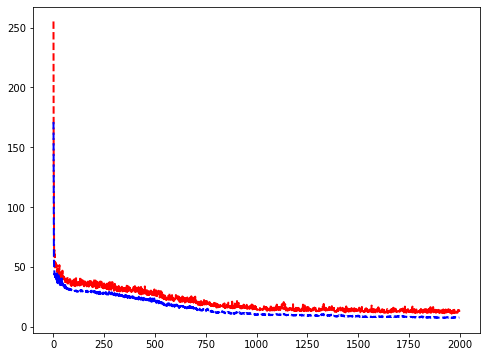

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(np.arange(epochs),training_loss_history,c="red",lw=2, ls= "--",label="\u03BC=3, \u03C3=0.5")
plt.plot(np.arange(epochs),test_loss_history,c="blue",lw=2, ls= "--",label="\u03BC=3, \u03C3=0.5")

In [ ]:
np.savetxt('training_loss_history_SNN.txt', training_loss_history, fmt='%.4f', delimiter=",")


# Deep Neural Network


### Implement DNN class


In [ ]:
class DNN:
    def __init__(self, input_size, layer_sizes, epochs=100, lr=0.001, batch_size=64):
        """
        Parameters
        ----------
        input_size: int
            Number of features in the inputs.
        layer_sizes: list
            Number of units in each hidden layer and the output. 
        epochs: int
            Number of epochs to train the model
        lr: float
            Learning rate.
        batch_size: int
            Batch size.
        """
        self.input_size = input_size
        self.layer_sizes = layer_sizes
        self.batch_size = batch_size
        self.epochs = epochs
        self.lr = lr
        L = len(self.layer_sizes)
        self.L = L
       
        # Init model parameters
        self.params = self._init_params()
    
    def _init_params(self):
        """ 
        Initialize model parameters based on He method.

        Return
        ----------
        params: dict
            Initialized model parameters represented by key-value pairs.
        """
        self.input_size 
        self.layer_sizes
        self.batch_size
        self.L
        params = {}
        for i in range(1,self.L+1):
          if i ==1: 
            params["W"+str(1)] = np.random.randn(self.layer_sizes[0], self.input_size)*np.sqrt(2/self.input_size)
            params["b"+str(1)] = np.zeros((self.layer_sizes[0],1))
          else:
            params["W"+str(i)] = np.random.randn(self.layer_sizes[i-1], self.layer_sizes[i-2])*np.sqrt(2/self.layer_sizes[i-2])
            params["b"+str(i)] = np.zeros((self.layer_sizes[i-1],1))
        return  params
          
    def _relu(self, Z, derivative=False):
        """
        If derivative=False, return the result transformed by the ReLU function.
        If derivative=True, return the result transformed by the derivative of the ReLU function.
        
        Parameters
        ----------
        Z: ndarray
            Input of the given data.
        derivative: bool.
            Whether or not to take the derivative of the ReLU function.

        Return
        ----------
        A: ndarray
            Output of the transformed matrix.
        """
        if not derivative :
          return np.maximum(0,Z)
        if derivative:
          A = np.ones_like(Z)
          A[Z<=0] = 0 
          return A 


    def _forward(self, X):
        """
        Generates output predictions for the input samples with given params.
            
        Parameters
        ----------
        X: ndarray
            Input samples with shape of n x m where n is the feature dimension 
            and m is the number of samples.

        Return
        ----------
        output_layers: dict
            Outputs of each layer represented by key-value pairs.
        """
        # self.L          
        # self.params
        output_layers = {}
        output_layers["A0"]= X
        for i in range(1,self.L+1):
            output_layers["Z"+str(i)] = np.dot(self.params["W"+str(i)],output_layers["A"+str(i-1)])
            output_layers["A"+str(i)] = self._relu(output_layers["Z"+str(i)],derivative=False)
        return output_layers

    @staticmethod
    def mse(y_truth, y_pred):
        """
        Return the mean squared error between the ground truth and predictions.
            
        Parameters
        ----------
        y_truth: ndarray
            An 1 x m matrix of ground truth.
        y_pred: ndarray
            An 1 x m matrix of predictions.

        Return
        ----------
        loss: float
            Output of the mean squared error.
        """
        MSE = 0.5*np.mean((y_truth-y_pred)**2,axis = 1)
        return MSE
    
    def _backward(self, X, y, output_layers):
        """
        Return the gradient of the loss function with respect to the model's weights.
            
        Parameters
        ----------
        X: ndarray
            Input samples with shape of n x m where n is the feature dimension 
            and m is the number of samples.
        y: ndarray
            An 1 x m matrix of ground truth.
        output_layers: dict
            Outputs of each layer represented by key-value pairs.

        Return
        ----------
        gradients: dict
            Gradients of weights and intercepts at each layers.
        """
        # TODO: write your code here
        
        m = y.shape[1]
        self.L
        gradients = {}
        for i in reversed(range(1,self.L+1)):
            if i==self.L:
                gradients["dA"+str(i)] = np.mean(output_layers["A"+str(i)]-y,axis = 1)
                gradients["dZ"+str(i)] = gradients["dA"+str(i)]*self._relu(output_layers["Z"+str(i)], derivative=True)
                gradients["dW"+str(i)] = 1/m*np.dot(gradients["dZ"+str(i)],output_layers["A"+str(i-1)].T)
                gradients["db"+str(i)] = 1/m*np.sum(gradients["dZ"+str(i)],axis = 1, keepdims = True)
                gradients["dA"+str(i-1)] = np.dot(self.params["W"+str(i)].T,gradients["dZ"+str(i)])
            else:
                gradients["dZ"+str(i)] = gradients["dA"+str(i)]*self._relu(output_layers["Z"+str(i)], derivative=True)
                gradients["dW"+str(i)] = 1/m*np.dot(gradients["dZ"+str(i)],output_layers["A"+str(i-1)].T)
                gradients["db"+str(i)] = 1/m*np.sum(gradients["dZ"+str(i)],axis = 1, keepdims = True)
                gradients["dA"+str(i-1)] = np.dot(self.params["W"+str(i)].T,gradients["dZ"+str(i)])
        return gradients

    def _update(self, gradients):
        """
        Update network parameters according to the update rule of gradient descent. 
            
        Parameters
        ----------
        gradients: dict
            Parameter gradients.
        """
        
        for i in range(1,self.L+1):
          self.params["W"+str(i)] = self.params["W"+str(i)] - self.lr*gradients["dW"+str(i)]
          self.params["b"+str(i)] = self.params["b"+str(i)] - self.lr*gradients["db"+str(i)]

    def train(self, X_train, y_train, X_test, y_test):
        """
        Train the model based on mini-batch graient descent.

        Parameters
        ----------
        X_train: ndarray
            Features of the training data with shape n by m1.
        y_train: ndarray
            Labels of the training data with shape 1 by m1.
        X_test: ndarray
            Features of the training data with shape n by m2.
        y_test: ndarray
            Labels of the training data with shape 1 by m2.

        Return
        ----------
        training_loss_history: list
            Entries are average training losses of all iterations in one epoch.
        test_loss_history: list
            A record of test loss values.
        """
        ii = 0 
        self.batch_size
        training_loss_history = []
        test_loss_history = []
        for i in range(self.epochs):
            batches_X, batches_y = self._create_batches(X_train, y_train)
            training_loss = []  
            ii = ii+1        
            for X,y in zip(batches_X, batches_y):
                output_layers = self._forward(X)
                MSE= self.mse(y, output_layers["A"+str(self.L)])
                training_loss.append(MSE)
                gradients = self._backward(X, y, output_layers)
                self._update(gradients)
            training_loss_history.append(np.mean(training_loss))
            output_layers = self._forward(X_test)
            MSE_test = self.mse(y_test, output_layers["A"+str(self.L)])
            test_loss_history.append(MSE_test)

        return training_loss_history , test_loss_history , ii
        
    
    def _create_batches(self, X, y):
        """
            Split X and y into small batches with given batch size.

            Parameters
            ----------
            X: ndarray
                Features with shape n by m.
            y: ndarray
                Labels with shape k by m.
            batch_size: int
                Batch size.

            Return
            ----------
            batches_X: list
                Created small batches of X.
            batches_y: list
                Created small batches of y.
        """
        # Get the number of examples
        m = X.shape[1]
        # Get label dimension
        k = y.shape[0]

        # Init variables to save batches
        batches_X = []
        batches_y = []
        
        # Combine X and y
        data = np.vstack((X, y))
        np.random.shuffle(data.T)
            
        # Calcuate the number of mini batches
        n_minibatches = m // batch_size 

        for i in range(n_minibatches): 
            mini_batch = data[:, i * batch_size:(i + 1) * batch_size]        
            batches_X.append(mini_batch[:-k, :])
            batches_y.append(mini_batch[-k:, :])
            
        # Handle the rest data
        if m % batch_size != 0: 
            mini_batch = data[:, n_minibatches * batch_size:]        
            batches_X.append(mini_batch[:-k, :])
            batches_y.append(mini_batch[-k:, :])
            
        return batches_X, batches_y

In [ ]:
# Init hyperparameters
epochs =2000 
lr = 0.001
batch_size = 64
layer_sizes = [15, 13, 8, 1]
input_size = 13
# TODO: create an instance of your DNN class
Obj1 = DNN(input_size, layer_sizes, epochs=epochs, lr=0.001, batch_size=64)

# TODO: train the model
training_loss_history , test_loss_history,ii = Obj1.train(X_train, y_train, X_test, y_test)
len(training_loss_history)
ii

2000

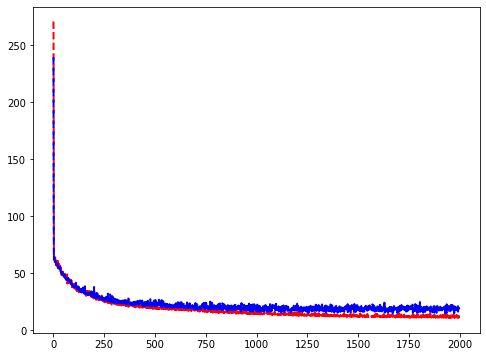

In [ ]:
# plot the training history
plt.figure(figsize=(8,6))
plt.plot(np.arange(epochs),training_loss_history,c="red",lw=2, ls= "--",label="\u03BC=3, \u03C3=0.5")
plt.plot(np.arange(epochs),test_loss_history,c="blue",lw=2, ls= "--",label="\u03BC=3, \u03C3=0.5")

np.savetxt('training_loss_history.txt', training_loss_history, fmt='%.4f', delimiter=",")
